### Навигация по проекту:

1. [Знакомство с данными](#start)
2. [Подготовка данных](#preprocessing)
3. [Исследовательский анализ данных](#EDA)
4. [Составление портрета пользователя каждого региона](#portrait)
5. [Проверка гипотез](#hypotheses)   
6. [Общий вывод](#conclusion)

### Шаг 0. Подключение библиотек

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats as st

### Шаг 1. Знакомство с данными <a id="start"></a> 

* Сперва загрузим файл и отобразим 5 строк

In [2]:
games = pd.read_csv('/datasets/games.csv')
games.head()

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN


* Изучим столбцы и их типы

In [3]:
games.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16713 non-null  object 
 1   Platform         16715 non-null  object 
 2   Year_of_Release  16446 non-null  float64
 3   Genre            16713 non-null  object 
 4   NA_sales         16715 non-null  float64
 5   EU_sales         16715 non-null  float64
 6   JP_sales         16715 non-null  float64
 7   Other_sales      16715 non-null  float64
 8   Critic_Score     8137 non-null   float64
 9   User_Score       10014 non-null  object 
 10  Rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


- Проверим пропуски

In [4]:
def nan_values(df,list_nans=['', ' ', '""', '" "', None, np.nan, pd.NA]):
    
    list_count=[]
    list_share=[]    
    
    for col in df.columns:
        list_count.append(sum(df[col].isin(list_nans)))
        list_share.append(round(sum(df[col].isin(list_nans)) * 100 / len(df), 2))
    
        
    missing_value_df = pd.DataFrame({'column_name': df.columns,
                                     'num_missing': list_count,
                                     'percent_missing': list_share})
    
    return missing_value_df

nan_values(games)

,column_name,num_missing,percent_missing
0,Name,2,0.01
1,Platform,0,0.00
2,Year_of_Release,269,1.61
3,Genre,2,0.01
4,NA_sales,0,0.00
5,EU_sales,0,0.00
6,JP_sales,0,0.00
7,Other_sales,0,0.00
8,Critic_Score,8578,51.32
9,User_Score,6701,40.09


Смотрим дубликаты:

In [5]:
display('Количество обнаруженных дубликатов:', games.duplicated().sum())

'Количество обнаруженных дубликатов:'

0

In [6]:
display('Количество обнаруженных дубликатов:', games[['Name', 'Platform', 'Year_of_Release']].duplicated().sum())
games = games.drop_duplicates().reset_index(drop=True)

'Количество обнаруженных дубликатов:'

2

_Вывод к шагу 1:_

Видим, что у нас есть 10 столбцов и 16715 строк.

Знакомимся с описанием и узнаём, что столбцы содержат следующие сведения:
- Name — название игры
- Platform — платформа
- Year_of_Release — год выпуска
- Genre — жанр игры
- NA_sales — продажи в Северной Америке (миллионы проданных копий)
- EU_sales — продажи в Европе (миллионы проданных копий)
- JP_sales — продажи в Японии (миллионы проданных копий)
- Other_sales — продажи в других странах (миллионы проданных копий)
- Critic_Score — оценка критиков (максимум 100)
- User_Score — оценка пользователей (максимум 10)
- Rating — рейтинг от организации ESRB (англ. Entertainment Software Rating Board). Эта ассоциация определяет рейтинг компьютерных игр и присваивает им подходящую возрастную категорию.


Видим также:
- наименования столбцов требуют корректировки в соответствии с правилом "хорошего тона" - приведения к нижнему регистру,
- есть несоответствующие содержащимся данным типы данных,
- есть пара дубликатов (удалили сразу),
- есть пропуски.

### Шаг 2. Подготовка данных <a id="preprocessing"></a> 

Внесем изменения, по порядку:
- Приведение названий столбцов к нижнему регистру

In [7]:
games.columns = games.columns.str.lower()

• Приведение данных к нужным типам

Данные столбцов 'year_of_release' и 'critic_score' не нуждаются в дробной части, приведем их к целочисленному типу int (только сначала обработаем пропуски, чтобы упростить себе задачу и не "бороться" с NaN). А данные столбца 'user_score' приведем к вещественному типу float.

In [8]:
games['user_score'] = pd.to_numeric(games['user_score'], errors='coerce')

При переводе данных в столбце с оценкой пользователей к вещественному типу мы натыкаемся на аббревиатуру 'tbd'. Это сокращение часто используется в сфере компьютерных игр и чаще всего расшифровывается, как To Be Determined, то есть "будет определено". В нашем случае значит, что оценка еще не установлена. Приравниваем эти строки к отсутствующему значению и заменяем на NaN, передавая аргументу errors значение 'coerce'.

In [9]:
#смотрим, сколько теперь пропусков, и где они

nan_values(games)

,column_name,num_missing,percent_missing
0,name,2,0.01
1,platform,0,0.00
2,year_of_release,269,1.61
3,genre,2,0.01
4,na_sales,0,0.00
5,eu_sales,0,0.00
6,jp_sales,0,0.00
7,other_sales,0,0.00
8,critic_score,8578,51.32
9,user_score,9125,54.59


У нас есть отсутствующие названия игр. Такой пропуск ничем не заменить, и их всего два. Можем удалить.

Есть пропуски в датах выхода игр. Если вопрос встанет критически, то можно, в целом, поискать информацию о конкретных играх в интернете и заполнить данные "вручную". Но пропуски составляют 1,6% (доля малая) всех строк, принимаю решение их тоже удалить.

In [10]:
games =  games.dropna(subset=['name', 'year_of_release'])

In [11]:
nan_values(games)

,column_name,num_missing,percent_missing
0,name,0,0.00
1,platform,0,0.00
2,year_of_release,0,0.00
3,genre,0,0.00
4,na_sales,0,0.00
5,eu_sales,0,0.00
6,jp_sales,0,0.00
7,other_sales,0,0.00
8,critic_score,8461,51.45
9,user_score,8981,54.62


Оставшиеся пропуски имеют высокую долю в имеющихся данных, удалять их нельзя. 


Остановимся на них и рассмотрим подробнее.

Пропуски по оценкам.

Посмотрим, к каким играм нет, например, оценок критиков.

In [12]:
 display(games[games['critic_score'].isna()])

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN
5,Tetris,GB,1989.0,Puzzle,23.20,2.26,4.22,0.58,NaN,NaN,NaN
9,Duck Hunt,NES,1984.0,Shooter,26.93,0.63,0.28,0.47,NaN,NaN,NaN
10,Nintendogs,DS,2005.0,Simulation,9.05,10.95,1.93,2.74,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
16710,Samurai Warriors: Sanada Maru,PS3,2016.0,Action,0.00,0.00,0.01,0.00,NaN,NaN,NaN
16711,LMA Manager 2007,X360,2006.0,Sports,0.00,0.01,0.00,0.00,NaN,NaN,NaN
16712,Haitaka no Psychedelica,PSV,2016.0,Adventure,0.00,0.00,0.01,0.00,NaN,NaN,NaN
16713,Spirits & Spells,GBA,2003.0,Platform,0.01,0.00,0.00,0.00,NaN,NaN,NaN


На основании полученных данных можно делать предположения о том, что отсутствие оценок может быть связано с отсутствием интереса к игре (нулевые продажи), отсутствием оценок вообще (давний период или совершенно новая).

Пропуски по рейтингу ESRB. 

Как указано в "Википедии", Entertainment Software Rating Board (ESRB) — это негосударственная организация, основное направление деятельности которой — принятие и определение рейтингов для компьютерных видеоигр и другого развлекательного программного обеспечения в США и Канаде. Отсюда предположение, что соответствующий рейтинг не определен для игр, произведенных и выпущенных в других странах мира. Эти пропуски заменить нечем, внесем маркерное значение 'нет рейтинга'.

In [14]:
games['rating'] = games['rating'].fillna('нет рейтинга')

In [15]:
#приведем к целочисленному типу

games['year_of_release'] = games['year_of_release'].astype(np.int64)
games['critic_score'] = pd.array(games['critic_score'].round(0), dtype=pd.Int64Dtype())

In [16]:
#смотрим, как прошли изменения

games.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16444 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16444 non-null  object 
 1   platform         16444 non-null  object 
 2   year_of_release  16444 non-null  int64  
 3   genre            16444 non-null  object 
 4   na_sales         16444 non-null  float64
 5   eu_sales         16444 non-null  float64
 6   jp_sales         16444 non-null  float64
 7   other_sales      16444 non-null  float64
 8   critic_score     7983 non-null   Int64  
 9   user_score       7463 non-null   float64
 10  rating           16444 non-null  object 
dtypes: Int64(1), float64(5), int64(1), object(4)
memory usage: 1.5+ MB


•	 Подсчет суммарных продаж во всех регионах и запись их в отдельный столбец.

In [17]:
games['total_sales'] = games['na_sales']+games['eu_sales']+games['jp_sales']+games['other_sales']
games.head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
0,Wii Sports,Wii,2006,Sports,41.36,28.96,3.77,8.45,76,8.0,E,82.54
1,Super Mario Bros.,NES,1985,Platform,29.08,3.58,6.81,0.77,<NA>,NaN,нет рейтинга,40.24
2,Mario Kart Wii,Wii,2008,Racing,15.68,12.76,3.79,3.29,82,8.3,E,35.52
3,Wii Sports Resort,Wii,2009,Sports,15.61,10.93,3.28,2.95,80,8.0,E,32.77
4,Pokemon Red/Pokemon Blue,GB,1996,Role-Playing,11.27,8.89,10.22,1.00,<NA>,NaN,нет рейтинга,31.38



Можно еще взять метод **sum** с аргументом **axis=1**.
    
</div>

```python


df['total_sales'] = df[['na_sales','eu_sales','jp_sales','other_sales']].sum(axis=1)
```

_Вывод к шагу 2:_

При проверке данных на пропуски было обнаружено, что в столбцах, содержащих название игры, дату выхода и жанр, пропущено до 2% значений. Эти строки мы удалили. И был большой объем пропусков (свыше 50%) в столбцах с данными об оценках критиков и пользователей, а также присвоенному рейтингу ESRB (процент пропусков свыше 40). Эти данные нельзя было удалить ввиду их объема, и оценки были оставлены без изменений, а пропуски в рейтинге ESRB были заменены маркерным значением 'нет рейтинга'.

Просмотрев строки с отсутствующими оценками критиков, можно предположить, что пропуски могли образоваться по ряду причин, таких, как, например:
- игра не вызвала интереса (нулевые продажи), и ее не оценивали;
- игра достаточно давняя, и в тот период не собирали оценки;
- игра совершенно новая, и по ней не успели собрать оценки;
- данные могли быть пропущены - человеческий фактор.

### Шаг 3. Исследовательский анализ данных <a id="EDA"></a> 


- Посмотрим, сколько игр выпускалось в разные годы, и оценим, так ли важны данные за все периоды


In [18]:
games.groupby('year_of_release')['name'].count()

year_of_release
1980       9
1981      46
1982      36
1983      17
1984      14
1985      14
1986      21
1987      16
1988      15
1989      17
1990      16
1991      41
1992      43
1993      60
1994     121
1995     219
1996     263
1997     289
1998     379
1999     338
2000     350
2001     482
2002     829
2003     775
2004     762
2005     939
2006    1006
2007    1197
2008    1427
2009    1426
2010    1255
2011    1136
2012     653
2013     544
2014     581
2015     606
2016     502
Name: name, dtype: int64

<Figure size 936x1080 with 0 Axes>

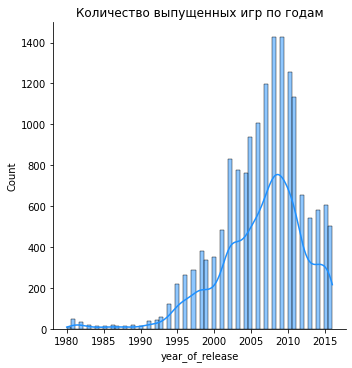

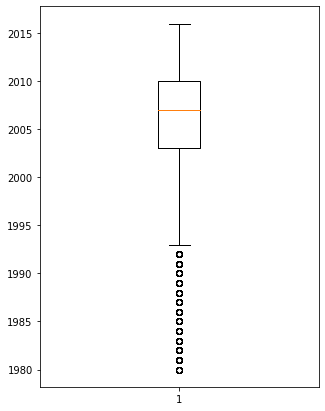

In [19]:
plt.figure(figsize=(13,15))
sns.displot(x='year_of_release',
            kde=True,
            data=games, color='dodgerblue')
plt.title('Количество выпущенных игр по годам')
plt.show()

plt.figure(figsize=(5,7))
plt.boxplot(games['year_of_release'])
plt.show()

_Вывод к шагу 3. Объем выпущенных игр:_

Посчитанные данные и графики показывают, что до 1994 года было выпущено настолько мало игр, что их количество в общей массе  являет собой выбросы. Чтобы они не влияли на наши прогнозы, отсечем их.

In [20]:
actual_games = games.query('year_of_release>=1994')
actual_games

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
0,Wii Sports,Wii,2006,Sports,41.36,28.96,3.77,8.45,76,8.0,E,82.54
2,Mario Kart Wii,Wii,2008,Racing,15.68,12.76,3.79,3.29,82,8.3,E,35.52
3,Wii Sports Resort,Wii,2009,Sports,15.61,10.93,3.28,2.95,80,8.0,E,32.77
4,Pokemon Red/Pokemon Blue,GB,1996,Role-Playing,11.27,8.89,10.22,1.00,<NA>,NaN,нет рейтинга,31.38
6,New Super Mario Bros.,DS,2006,Platform,11.28,9.14,6.50,2.88,89,8.5,E,29.80
...,...,...,...,...,...,...,...,...,...,...,...,...
16710,Samurai Warriors: Sanada Maru,PS3,2016,Action,0.00,0.00,0.01,0.00,<NA>,NaN,нет рейтинга,0.01
16711,LMA Manager 2007,X360,2006,Sports,0.00,0.01,0.00,0.00,<NA>,NaN,нет рейтинга,0.01
16712,Haitaka no Psychedelica,PSV,2016,Adventure,0.00,0.00,0.01,0.00,<NA>,NaN,нет рейтинга,0.01
16713,Spirits & Spells,GBA,2003,Platform,0.01,0.00,0.00,0.00,<NA>,NaN,нет рейтинга,0.01


- Посмотрим, как менялись продажи по платформам. Выберем платформы с наибольшими суммарными продажами и построим распределение по годам. Выявим, за какой характерный срок появляются новые и исчезают старые платформы.

In [21]:
#платформы с наибольшими суммарными продажами

actual_games \
    .pivot_table(index='platform', values='total_sales', aggfunc='sum') \
    .sort_values(by='total_sales', ascending=False)

,total_sales
platform,
PS2,1233.56
X360,961.24
PS3,931.34
Wii,891.18
DS,802.76
PS,727.58
PS4,314.14
GBA,312.88
PSP,289.53


In [22]:
#оставим 10 самых продающих платформ

platform_raiting = actual_games \
    .pivot_table(index='platform', values='total_sales', aggfunc='sum').reset_index().query('total_sales>255')

In [23]:
top_platforms = actual_games.query('platform in @platform_raiting.platform')
top_platforms.head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
0,Wii Sports,Wii,2006,Sports,41.36,28.96,3.77,8.45,76,8.0,E,82.54
2,Mario Kart Wii,Wii,2008,Racing,15.68,12.76,3.79,3.29,82,8.3,E,35.52
3,Wii Sports Resort,Wii,2009,Sports,15.61,10.93,3.28,2.95,80,8.0,E,32.77
6,New Super Mario Bros.,DS,2006,Platform,11.28,9.14,6.50,2.88,89,8.5,E,29.80
7,Wii Play,Wii,2006,Misc,13.96,9.18,2.93,2.84,58,6.6,E,28.91


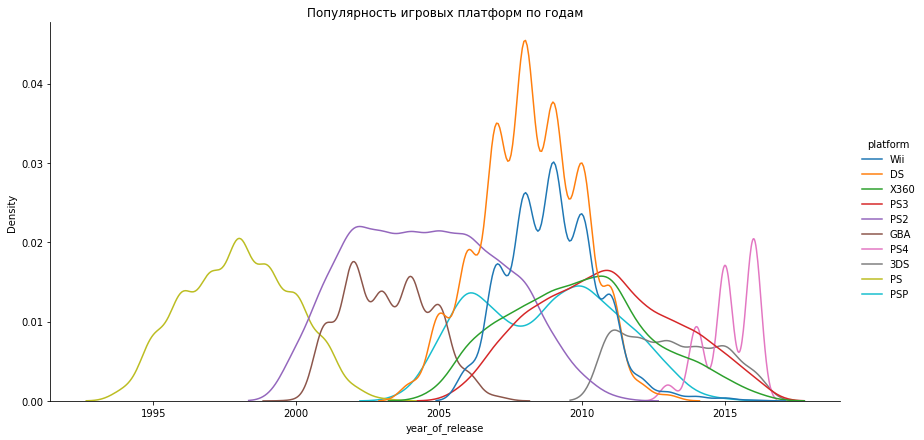

In [24]:
sns.displot(x='year_of_release',
            hue="platform",
            kind="kde",
            data=top_platforms, 
            height=6, aspect=2)
plt.title('Популярность игровых платформ по годам')
plt.show()

_Вывод к шагу 3. Актуальный период:_


Если судить по пикам графиков, то позиция лидера среди платформ сменяется, в среднем, в пределах пяти лет. А средний цикл жизни платформы - около 10 лет. Также, по графику видим, что в 2011 были очень высокие продажи, что может повлиять на наш анализ. Поэтому примем за актуальный период 5 лет, с 2012 года.

Чтобы определить, какие платформы лидируют по продажам, растут или падают, построим их графики продаж по годам. 

In [25]:
actual_period = actual_games.query('year_of_release>2011')

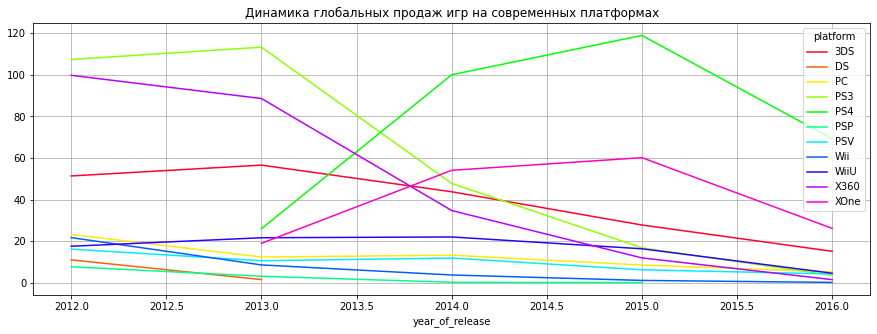

In [26]:
(actual_period
    .pivot_table(index='year_of_release', columns='platform', values='total_sales', aggfunc='sum')
    .plot(figsize=(15, 5), grid=True, cmap ='gist_rainbow')
)
plt.title('Динамика глобальных продаж игр на современных платформах')
plt.show()

In [27]:
# КОД РЕВЬЮЕРА

actual_period.pivot_table(index='year_of_release', columns='platform', values='total_sales', aggfunc='sum').loc[[2014, 2015, 2016]]

platform,3DS,DS,PC,PS3,PS4,PSP,PSV,Wii,WiiU,X360,XOne
year_of_release,,,,,,,,,,,
2014,43.76,NaN,13.28,47.76,100.00,0.24,11.90,3.75,22.03,34.74,54.07
2015,27.78,NaN,8.52,16.82,118.90,0.12,6.25,1.14,16.35,11.96,60.14
2016,15.14,NaN,5.25,3.60,69.25,NaN,4.25,0.18,4.60,1.52,26.15


_Вывод к шагу 3. Потенциально прибыльные платформы:_

Видим, что карьера платформ X360, PS3, Wii, явно клонится к закату, платформы 3DS, PSV и WiiU все еще акутальны, а появившиеся в 2013 году платформы XOne и PS4, напротив, идут в рост.
Кроме того, можно также рассмотреть и 'PC', потому что у компьютеров своя аудитория.

Для дальнейшего анализа, как потенциально прибыльные, оставим эти платформы: PS4, XOne, 3DS, PSV, WiiU, PC.

In [28]:
top_six = ['PS4', 'XOne', '3DS', 'PSV','WiiU','PC']
potentially_profitable = actual_period.query('platform in @top_six')

•	Построим график «ящик с усами» по глобальным продажам игр в разбивке по платформам.



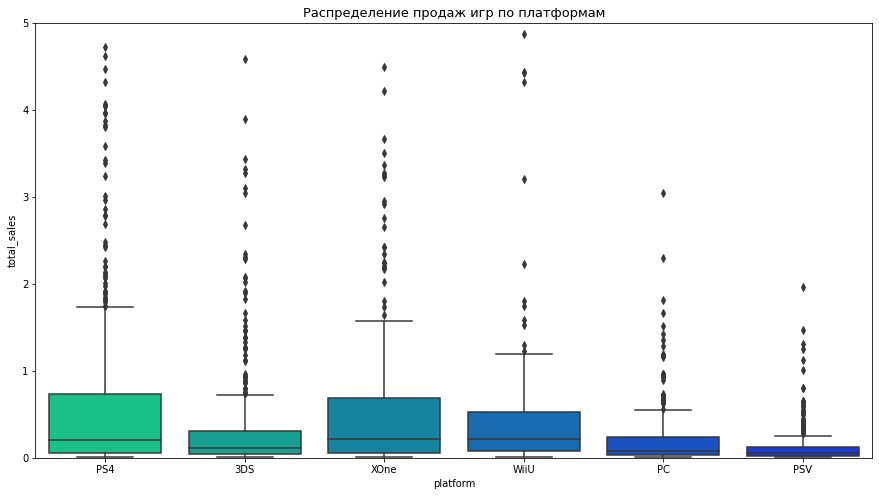

In [29]:
plt.figure(figsize=(15,8))
sns.boxplot(x=potentially_profitable["platform"], y=potentially_profitable["total_sales"], palette = 'winter_r')
plt.title('Распределение продаж игр по платформам', fontsize=13)
plt.ylim(0, 5)
plt.show()

In [30]:
potentially_profitable.groupby('platform')['total_sales'].describe()

,count,mean,std,min,25%,50%,75%,max
platform,,,,,,,,
3DS,396.0,0.491439,1.387161,0.01,0.04,0.11,0.3125,14.60
PC,250.0,0.250600,0.494640,0.01,0.03,0.08,0.2400,5.14
PS4,392.0,0.801378,1.609456,0.01,0.06,0.20,0.7300,14.63
PSV,411.0,0.119659,0.203011,0.01,0.02,0.05,0.1200,1.96
WiiU,147.0,0.559116,1.058836,0.01,0.08,0.22,0.5250,7.09
XOne,247.0,0.645020,1.036139,0.01,0.06,0.22,0.6850,7.39


_Вывод к шагу 3. Оценка глобальных продаж игр в разбивке по платформам:_

Исходя из полученных данных, можем заключить, что было продано до 2 млн копий каждой отдельной игры на платформах PS4 и XOne, до 1 млн - на платформе WiiU и  меньше - на всех остальных. А в среднем у тройки лидеров - 0.8, 0.65 и 0.56 млн копий.

Кроме того, есть заметные выбросы в продажах игр на платформах PS4 и 3DS. Возможно, это связано с отдельными коммерчески успешными играми, исключительными правами на них.

•	Посмотрим, как влияют на продажи внутри одной популярной платформы отзывы пользователей и критиков. Построим диаграмму рассеяния и посчитаем корреляцию между отзывами и продажами. 


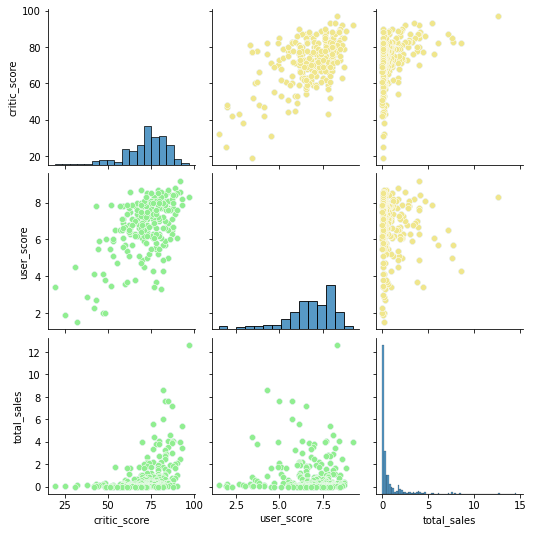

In [31]:
sns.pairplot(potentially_profitable.query('platform=="PS4"')[['critic_score', 'user_score', 'total_sales']]).map_upper(sns.scatterplot,color='khaki').map_lower(sns.scatterplot, color='lightgreen')
plt.show()

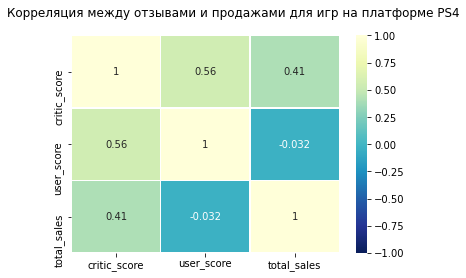

In [32]:
sns.heatmap(potentially_profitable.query('platform=="PS4"')[['critic_score', 'user_score', 'total_sales']].corr(), vmin=-1, vmax=1,linewidths=.5, cmap='YlGnBu_r', annot=True)
plt.suptitle('Корреляция между отзывами и продажами для игр на платформе PS4')
plt.show()

_Вывод к шагу 3. Влияние отзывов пользователей и критиков на продажи (на примере платформы PS4):_

Есть умеренная прямая корреляция между оценками критиков и продажами - 0.41. И если смотреть на диаграммы рассеяния, то можно увидеть, что в оценке коммерчески успешных игр критики, в целом, единогласны. Тогда как оценки пользователей имеют большой разброс, и порой низко оцененные игры все же продаются большим числом копий. Применительно к нашим целям, это говорит о том, что при планировании рекламной кампании, если и брать в учет рейтинги, то предпочтительнее руководствоваться оценкой критиков, а не пользователей.

•	Соотнесем выводы с продажами игр на других платформах. Для этого так же построим диаграммы рассеяния и посчитаем корреляции:

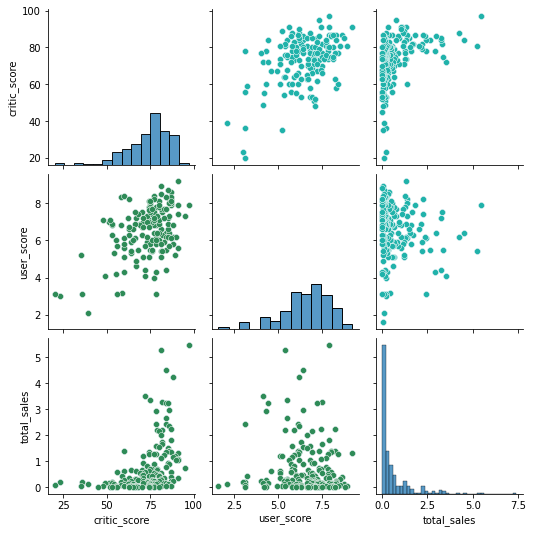

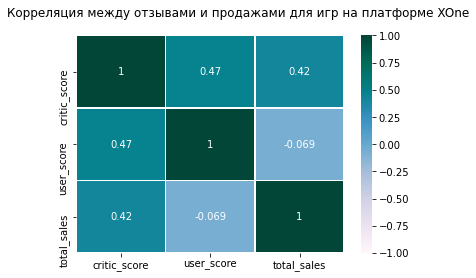

In [33]:
sns.pairplot(potentially_profitable.query('platform=="XOne"')[['critic_score', 'user_score', 'total_sales']]).map_upper(sns.scatterplot,color='lightseagreen').map_lower(sns.scatterplot, color='seagreen')
plt.show()
sns.heatmap(potentially_profitable.query('platform=="XOne"')[['critic_score', 'user_score', 'total_sales']].corr(), vmin=-1, vmax=1,linewidths=.5, cmap='PuBuGn', annot=True)
plt.suptitle('Корреляция между отзывами и продажами для игр на платформе XOne')
plt.show()

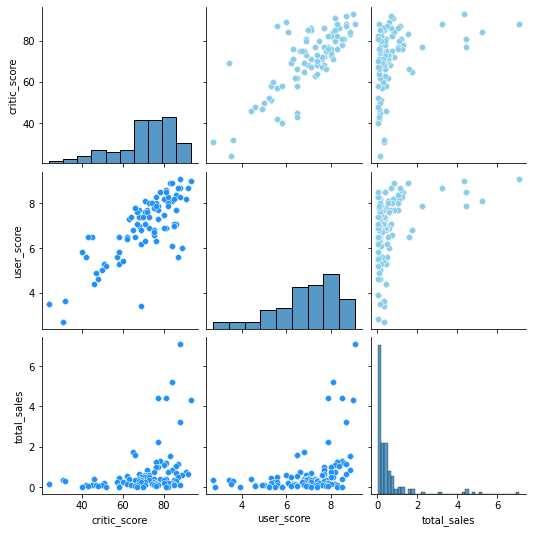

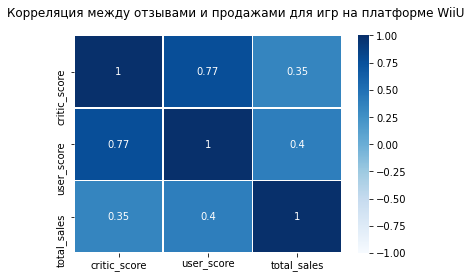

In [34]:
sns.pairplot(potentially_profitable.query('platform=="WiiU"')[['critic_score', 'user_score', 'total_sales']]).map_upper(sns.scatterplot,color='skyblue').map_lower(sns.scatterplot, color='dodgerblue')
plt.show()
sns.heatmap(potentially_profitable.query('platform=="WiiU"')[['critic_score', 'user_score', 'total_sales']].corr(), vmin=-1, vmax=1,linewidths=.5, cmap='Blues', annot=True)
plt.suptitle('Корреляция между отзывами и продажами для игр на платформе WiiU')
plt.show()

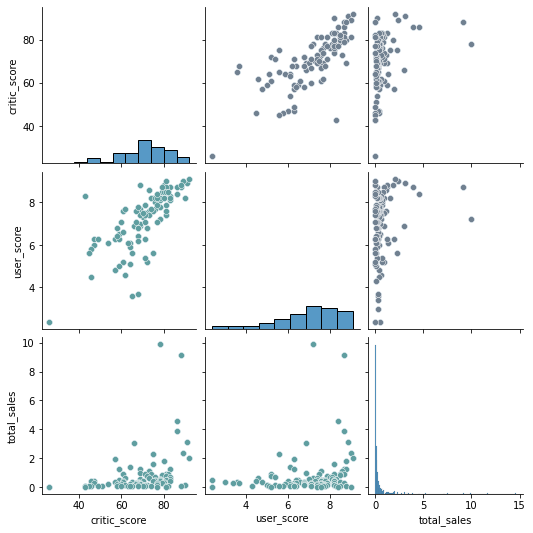

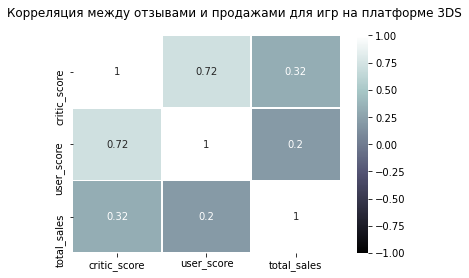

In [35]:
sns.pairplot(potentially_profitable.query('platform=="3DS"')[['critic_score', 'user_score', 'total_sales']]).map_upper(sns.scatterplot,color='slategrey').map_lower(sns.scatterplot, color='cadetblue')
plt.show()
sns.heatmap(potentially_profitable.query('platform=="3DS"')[['critic_score', 'user_score', 'total_sales']].corr(), vmin=-1, vmax=1,linewidths=.5, cmap='bone', annot=True)
plt.suptitle('Корреляция между отзывами и продажами для игр на платформе 3DS')
plt.show()

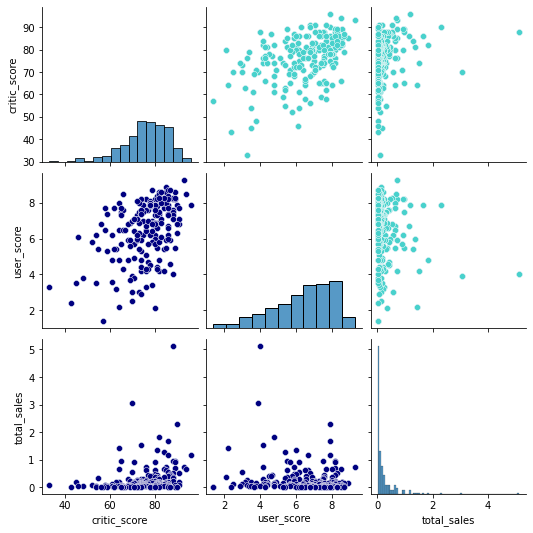

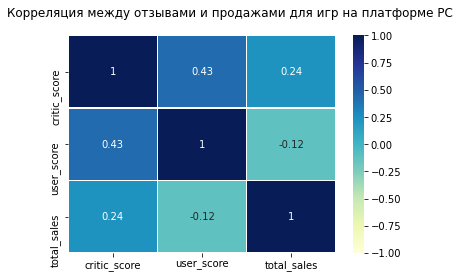

In [36]:
sns.pairplot(potentially_profitable.query('platform=="PC"')[['critic_score', 'user_score', 'total_sales']]).map_upper(sns.scatterplot,color='mediumturquoise').map_lower(sns.scatterplot, color='navy')
plt.show()
sns.heatmap(potentially_profitable.query('platform=="PC"')[['critic_score', 'user_score', 'total_sales']].corr(), vmin=-1, vmax=1,linewidths=.5, cmap='YlGnBu', annot=True)
plt.suptitle('Корреляция между отзывами и продажами для игр на платформе PC')
plt.show()

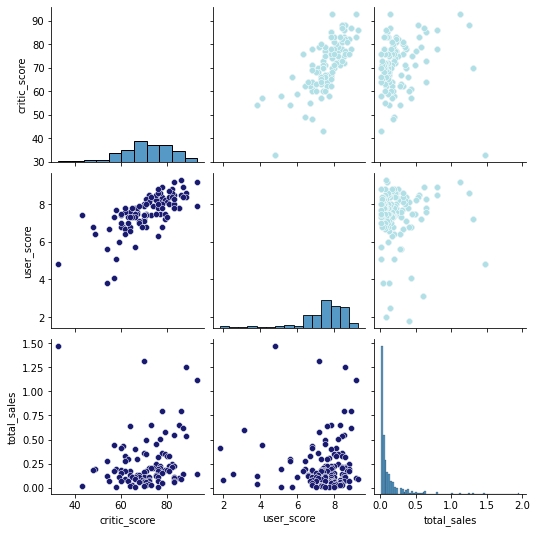

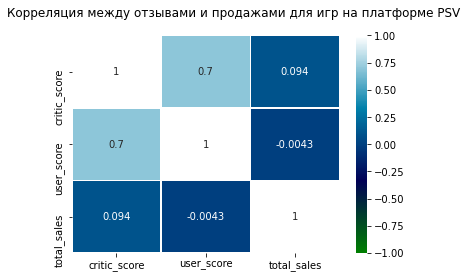

In [37]:
sns.pairplot(potentially_profitable.query('platform=="PSV"')[['critic_score', 'user_score', 'total_sales']]).map_upper(sns.scatterplot,color='powderblue').map_lower(sns.scatterplot, color='midnightblue')
plt.show()
sns.heatmap(potentially_profitable.query('platform=="PSV"')[['critic_score', 'user_score', 'total_sales']].corr(), vmin=-1, vmax=1,linewidths=.5, cmap='ocean', annot=True)
plt.suptitle('Корреляция между отзывами и продажами для игр на платформе PSV')
plt.show()

_Вывод к шагу 3. Влияние отзывов пользователей и критиков на продажи (на других платформах):_

Корреляция между оценками критиков и продажами игр на других платформах-лидерах продаж близкая к корреляции, вычисленной для PS4, - 0.42 для XOne, 0.35 для WiiU и 0.32 для 3DS . Для игр на платформе PC корреляция составляет 0.24, для PSV - всего 0.09 (практически отсутствует). Но объем продаж этих игр, как мы видим, небольшой в принципе, какими бы ни были оценки.
Потому, в целом, можно утверждать, что рассматриваемый показатель достаточно универсален, и его можно учитывать при планировании продаж.

Корреляция между продажами и пользовательскими оценками игр очень низкая, в некоторых случаях обратная (диаграммы схожи с PS4), мы не можем полагаться на этот фактор. А пользовательские оценки игр на WiiU коррелируют с продажами ровно, как оценки критиков.


• И наконец, посмотрим на общее распределение игр по жанрам. 

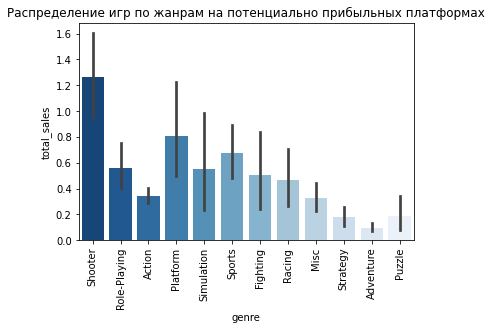

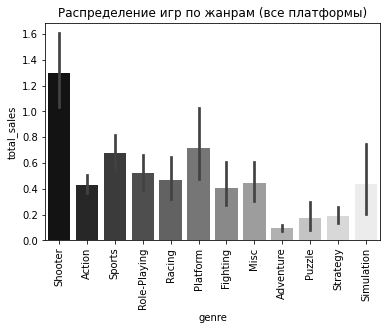

In [38]:
sns.barplot(x='genre', y='total_sales', data=potentially_profitable, palette='Blues_r')
plt.title('Распределение игр по жанрам на потенциально прибыльных платформах')
plt.xticks(rotation=90)
plt.show()

sns.barplot(x='genre', y='total_sales', data=actual_period, palette='gray', order=['Shooter', 'Action', 'Sports', 'Role-Playing', 'Racing',
       'Platform', 'Fighting', 'Misc', 'Adventure', 'Puzzle', 'Strategy',
       'Simulation'])
plt.title('Распределение игр по жанрам (все платформы)')
plt.xticks(rotation=90)
plt.show()

_Вывод к шагу 3. Оценка популярности жанров:_

Мы построили диаграммы распределения игр по жанрам на выбранных потенциально прибыльных платформах и на всех платформах вообще - за актуальный период, равный десяти годам. И обнаружили жанры с ярковыраженными высокими и низкими продажами:

-на выбранных платформах безоговорочные бестселлеры - жанры 'shooter', 'platform' и 'sports';


-наименее успешные в продажах на тех же платформах жанры 'puzzle', 'strategy', 'adventure';


-самые популярные среди игр на всех платформах вообще - так же игры в жанрах 'shooter', 'platform', 'sports', и самые низкие продажи у жанров  'puzzle', 'strategy', 'adventure'.

Платформы приходят и уходят, а вкусы пользователей сменяются не так быстро.

### Шаг 4. Составление портрета пользователя каждого региона <a id="portrait"></a> 

Рассмотрим предпочтения пользователей каждого региона (NA, EU, JP) отдельно и выявим:

- Самые популярные платформы 

- Самые популярные жанры 

- Влияние рейтинга ESRB на продажи в отдельном регионе

In [39]:
#суммарные продажи игр на различных платформах и их доля в общих продажах - в Северной Америке:

na_total = actual_period['na_sales'].sum()
na_pivot = actual_period.pivot_table(index='platform', values='na_sales', aggfunc=['sum', (lambda x: sum(x)/na_total*100)]).reset_index().droplevel(1, axis=1)
na_pivot.rename(columns={'sum': 'na_sum_sales', '<lambda>': 'na_percentage'}, inplace=True)
na_pivot.sort_values(by='na_sum_sales', ascending=False)

,platform,na_sum_sales,na_percentage
9,X360,140.05,23.698326
4,PS4,108.74,18.400257
3,PS3,103.38,17.493274
10,XOne,93.12,15.757145
0,3DS,55.31,9.359189
8,WiiU,38.10,6.447028
2,PC,19.12,3.235359
7,Wii,17.45,2.952773
6,PSV,10.98,1.857962
1,DS,4.59,0.776689


In [40]:
#суммарные продажи игр на различных платформах и их доля в общих продажах - в Европе:

eu_total = actual_period['eu_sales'].sum()
eu_pivot = actual_period.pivot_table(index='platform', values='eu_sales', aggfunc=['sum', (lambda x: sum(x)/eu_total*100)]).reset_index().droplevel(1, axis=1)
eu_pivot.rename(columns={'sum': 'eu_sum_sales', '<lambda>': 'eu_percentage'}, inplace=True)
eu_pivot.sort_values(by='eu_sum_sales', ascending=False)

,platform,eu_sum_sales,eu_percentage
4,PS4,141.09,27.838286
3,PS3,106.86,21.084409
9,X360,74.52,14.703445
10,XOne,51.59,10.179156
0,3DS,42.64,8.413243
2,PC,37.76,7.450377
8,WiiU,25.13,4.958368
7,Wii,11.92,2.351920
6,PSV,11.36,2.241427
1,DS,3.53,0.696500


In [41]:
#суммарные продажи игр на различных платформах и их доля в общих продажах - в Японии:

jp_total = actual_period['jp_sales'].sum()
jp_pivot = actual_period.pivot_table(index='platform', values='jp_sales', aggfunc=['sum', (lambda x: sum(x)/jp_total*100)]).reset_index().droplevel(1, axis=1)
jp_pivot.rename(columns={'sum': 'jp_sum_sales', '<lambda>': 'jp_percentage'}, inplace=True)
jp_pivot.sort_values(by='jp_sum_sales', ascending=False)

,platform,jp_sum_sales,jp_percentage
0,3DS,87.79,45.586250
3,PS3,35.29,18.324852
6,PSV,21.04,10.925330
4,PS4,15.96,8.287465
8,WiiU,13.01,6.755634
5,PSP,10.47,5.436702
1,DS,3.72,1.931665
7,Wii,3.39,1.760307
9,X360,1.57,0.815246
10,XOne,0.34,0.176550


In [42]:
# и посмотрим предпочтения по жанрам

display(actual_period.groupby('genre')['na_sales'].sum().sort_values(ascending=False))
display()
display(actual_period.groupby('genre')['eu_sales'].sum().sort_values(ascending=False))
display()
display(actual_period.groupby('genre')['jp_sales'].sum().sort_values(ascending=False))

genre
Action          177.84
Shooter         144.77
Sports           81.53
Role-Playing     64.00
Misc             38.19
Platform         25.38
Fighting         19.79
Racing           17.22
Adventure         8.92
Simulation        7.97
Strategy          4.23
Puzzle            1.13
Name: na_sales, dtype: float64

genre
Action          159.34
Shooter         113.47
Sports           69.09
Role-Playing     48.53
Racing           27.29
Misc             26.32
Platform         21.41
Simulation       14.55
Fighting         10.79
Adventure         9.46
Strategy          5.17
Puzzle            1.40
Name: eu_sales, dtype: float64

genre
Role-Playing    65.44
Action          52.80
Misc            12.86
Simulation      10.41
Fighting         9.44
Shooter          9.23
Platform         8.63
Adventure        8.24
Sports           8.01
Strategy         2.88
Racing           2.50
Puzzle           2.14
Name: jp_sales, dtype: float64

На основании полученных сводных таблиц можем составить портреты:

- игрокам из Северной Америки по вкусу:

платформы X360 (23.7% от общих продаж), PS4 (18.4%), PS3 (17.5%), XOne (15.8%) и 3DS (9.4%), жанры 'action', shooter', sports', 'role-playing', 'misc';


- игроки из Европы предпочитают:


платформы PS4 (27.8% от общих продаж), PS3 (21.1%), X360 (14.7%), XOne (10.2%), 3DS (8.4%) и игры в жанрах 'action', shooter', 'sports', 'role-playing', 'racing';


- а игроки, проживающие в Японии, выбирают:

платформы 3DS (45.6% от общих продаж), PS3 (18.3%), PSV (10.9%), PS4 (8.3%), WiiU (6.8%) и игры, обозначенные жанрами 'role-playing', 'action', 'misc', 'simulation', 'fighting'.


Видим, что японцы выбирают исключительно отечественных производителей консолей (PlayStation, как известно, наполовину японская). А их предпочтения именно этих жанров (заметим, отличных от набора европейцев и североамериканцев) могут быть обусловлены историческими предпосылками: большинство блокбастеров было разработано именно в Японии, и часть из них - изначально - только для внутреннего рынка.




В дополнение, рассмотрим возрастные категории игроков. В части игр мы располагаем сведениями о рейтинге ESRB.

Обозначения рейтингов расшифровываются следующим образом:

- «E» («Everyone») — «Для всех» (от 6 лет)
- «E10+» («Everyone 10 and older») — «Для всех от 10 лет и старше»
- «T» («Teen») — «Подросткам»
- «M» («Mature») — «Для взрослых»

In [43]:
display(actual_period.groupby('rating')['na_sales'].sum().sort_values(ascending=False))
display()
display(actual_period.groupby('rating')['eu_sales'].sum().sort_values(ascending=False))
display()
display(actual_period.groupby('rating')['jp_sales'].sum().sort_values(ascending=False))

rating
M               231.57
E               114.37
нет рейтинга    103.31
E10+             75.70
T                66.02
Name: na_sales, dtype: float64

rating
M               193.96
E               113.03
нет рейтинга     91.50
E10+             55.37
T                52.96
Name: eu_sales, dtype: float64

rating
нет рейтинга    108.84
E                28.33
T                26.02
M                21.20
E10+              8.19
Name: jp_sales, dtype: float64

Полученные таблицы распределения указывают на то, что в Северной Америке и Европе (рейтинги распределены одинаково) наибольшей популярностью пользуются игры, рекомендованные взрослым, или с широким диапазоном - от 6 лет. Игры для детей и подростков интересны им в меньшей степени. 
А большинство японских игроков (в рамках системы оценок ESRB) относится к младшему школьному возрасту и подросткам. 

Однако, ключевой момент состоит в том, что в покупках японцев преобладают игры без рейтинга ESRB. Что может быть исчерпывающе объяснено тем, что в Японии работает своя некоммерческая организация - CERO, присуждающая рейтинги компьютерным играм и программному обеспечению для их последующей продажи на территории страны.

_Вывод к шагу 4:_

Предпочтения игровых платформ и жанров (топ-5 популярных) среди пользователей компьютерных игр в Европе и Северной Америке совпадают. А у японцев другие, отличающиеся вкусы. Это важно учитывать при построении стратегии продаж.

Так же стоит отметить, что оценивать покупательское поведение японцев по системе рейтингов ESRB некорректно, - у них своя рейтинговая организация.

### Шаг 5. Проверка гипотез <a id="hypotheses"></a> 

•	На равенство средних пользовательских рейтингов платформ XOne и PC;


•	На разность средних пользовательских рейтингов жанров 'action' и 'sports'.

Первая гипотеза.


Предположим, средние пользовательские рейтинги платформ XOne и PC одинаковые. Сформулируем нулевую и альтернативную гипотезы:
- H0 - средние пользовательские рейтинги платформ XOne и PC равны
- H1 - средние пользовательские рейтинги платформ XOne и PC неравны

Возьмем из общей базы данных две выборки - пользовательские оценки платформы XOne и пользовательские оценки платформы PC. Поскольку выборки независимы, используем метод st.ttest_ind. И поскольку выборки разного размера, и можно предполагать, что их дисперсии разные, укажем параметр equal_var = False. Критический уровень статистической значимости возьмем 0.01. Проведем тест, и если вероятность того, что средние этих выборок окажутся очень близко (или равны), будет меньше заявленного критического уровня значимости, отвергнем нулевую гипотезу, как неподтвержденную.

In [44]:
#выборки по платформам
xone_userscore = actual_period[actual_period['platform']=='XOne']['user_score']
pc_userscore = actual_period[actual_period['platform']=='PC']['user_score']

alpha = .01


results = st.ttest_ind(xone_userscore, pc_userscore, equal_var = False, nan_policy='omit')

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу") 

p-значение: 0.5489537965134987
Не получилось отвергнуть нулевую гипотезу


Вторая гипотеза.

Предположим, средний пользовательский рейтинг жанра 'action' отличается от соответствующего критерия жанра 'sports'. Нулевая и альтернативная гипотеза будут следующими:
- H0 - средние пользовательские рейтинги жанров 'action' и 'sports' равны
- H1 - средние пользовательские рейтинги жанров 'action' и 'sports' неравны

In [45]:
#выборки по жанрам
action_userscore = actual_period[actual_period['genre']=='Action']['user_score']
sports_userscore = actual_period[actual_period['genre']=='Sports']['user_score']

alpha = .01

results = st.ttest_ind(action_userscore, sports_userscore, equal_var = False, nan_policy='omit')

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу") 

p-значение: 4.24307776572644e-20
Отвергаем нулевую гипотезу


Можем визуально представить интересующие нас данные и на графиках распределения увидеть, как разбросаны значения пользовательских оценок обеих выборок по жанрам:

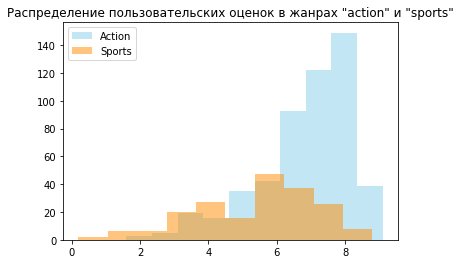

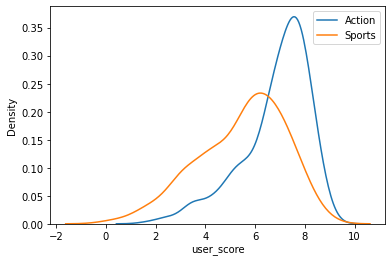

In [46]:
plt.hist(actual_period[actual_period['genre']=='Action']['user_score'], alpha=0.5, color='skyblue', bins=10)
plt.hist(actual_period[actual_period['genre']=='Sports']['user_score'], alpha=0.5, color='darkorange', bins=10)
plt.title('Распределение пользовательских оценок в жанрах "action" и "sports"')
plt.legend(['Action', 'Sports'])
plt.show()
sns.kdeplot(data=actual_period[actual_period['genre']=='Action'], x='user_score')
sns.kdeplot(data=actual_period[actual_period['genre']=='Sports'], x='user_score')
plt.legend(['Action', 'Sports'])
plt.show()

_Вывод к шагу 5:_

При тестировании гипотезы на равенство средних пользовательских рейтингов платформ XOne и PC получили результат, не позволящий нам ее отвергнуть.
И проверка гипотезы о разности средних пользовательских рейтингов жанров 'action' и 'sports' дала положительный результат: отношение пользователей к ним неодинаково.

### Шаг 6. Общий вывод <a id="conclusion"></a> 

В моем распоряжении были данные о продажах игр за последние несколько лет. Было необходимо провести исследовательский анализ для выявления определяющих успешность игры закономерностей и потенциально прибыльных направлений будущих рекламных кампаний.
Работа прошла в несколько этапов-шагов:

- Была произведена предобработка данных. 
    
   
- На основе анализа популярных платформ и их жизненного цикла был выявлен актуальный период. 
    
    
    
- Определены перспективные платформ и проанализировано влияние оценок критиков и пользователей на продажи.
    
    
  
- Выявлены популярные жанры и разница в пользовательских предпочтениях в трех регионах.
    
    
- Проведены статистические тесты. 
    
    
Коротко об итогах: 
    
    
В рамках выбранного периода (5 лет) актуальными остаются платформы 3DS, PSV и WiiU (их продажи упали не так сильно, по-прежнему продается большое число игр), при этом PS4 и XOne можно считать перспективными на 2017 год.
Влияние оценки критиков на продажи слабое, скорее, высокие оценки подтверждают коммерческий успех. А пользовательские оценки вовсе не устойчивы, и полагаться на них не стоит.  

Успешные жанры - 'shooter', 'platform' и 'sports', а наименее востребованные - 'puzzle', 'strategy', 'adventure'.
    
        
Пользователи США и Европы совпадают в своих предпочтениях: 
выбирают преимущественно 
платформы X360, PS4 и  PS3, жанры 'action', 'shooter', 'sports', игры рейтинга ESRB 'M' и 'E'.


А игроки, проживающие в Японии, выбирают
платформы 3DS, PS3 и PSV, жанры 'role-playing', 'action', 'misc' и  игры без рейтинга ESRB (что объясняется тем, что в Японии работает своя рейтинговая организация - CERO).


И пара слов про гипотезы:

При тестировании гипотезы на равенство средних пользовательских рейтингов платформ XOne и PC получили результат, не позволящий нам ее отвергнуть. А гипотеза о равенстве средних пользовательских рейтингов жанров 'action' и 'sports' не подтвердилась.


Резюмируя, можно сказать следующее:  планируя рекламные кампании, стоит ориентироваться на все еще актуальные платформы 3DS, PSV и WiiU и потенциально перспективные XOne и PS4. Пользователям из Европы и Северной Америки целесообразнее предлагать игры в жанрах 'action', 'shooter', 'sports' и рейтинга ESRB 'M','E'. Для продаж в Японии стоит сделать акцент на жанрах 'role-playing', 'action', 'misc', а полагаться на рейтинг ESRB некорректно (нужно проводить анализ рейтинга CERO). Так же ненадежны факторы оценки критиков и пользователей, их учитывать не стоит.